In [1]:
%matplotlib inline

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.distributions import ECDF

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.covariance import EmpiricalCovariance
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier, plot_importance

from santander.preprocessing import ColumnDropper
from santander.preprocessing import ZERO_VARIANCE_COLUMNS, CORRELATED_COLUMNS
from santander.feature_extraction import BOW, Featurizer

In [4]:
df_train = pd.read_csv('../data/train.csv')
df_target = df_train['TARGET']
df_train = df_train.drop(['TARGET', 'ID'], axis=1)

Best log loss train=0.123817 (round=599), test=0.139076 (round=599)
Best AUC train=0.884611 (round=599), test=0.832920 (round=517)


,feature,importance
0,var38,4548
1,var15,2460
2,saldo_var30,1321
3,saldo_medio_var5_hace2,1249
4,num_zero,1155
5,saldo_medio_var5_hace3,1127
6,saldo_medio_var5_ult3,968
7,num_var22_ult3,773
8,num_var45_hace3,681
9,num_var22_ult1,680


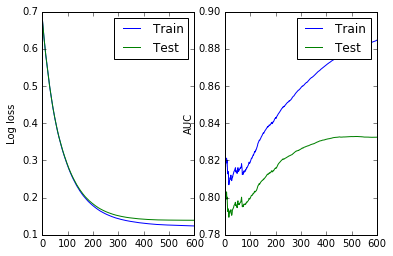

In [5]:
# xgb on basic features + zero features
pipeline = Pipeline([
    ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS)),
])

X_train = pipeline.fit_transform(df_train)
X_train['num_zero'] = (X_train == 0).sum(axis=1)
y_train = df_target
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# best params so far using column/row subsampling, even longer training
learning_rate = 0.01
n_estimators = 600
max_depth = 6
subsample = 0.9
colsample_bytree = 0.85
min_child_weight = 1  # default

eval_metrics = ['logloss', 'auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(seed=0, learning_rate=learning_rate, n_estimators=n_estimators,
                    min_child_weight=min_child_weight, max_depth=max_depth,
                    colsample_bytree=colsample_bytree, subsample=subsample)
xgb = xgb.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets, verbose=False)

logloss = [xgb.evals_result_['validation_%d' % i]['logloss'] for i in range(len(eval_sets))]
logloss = np.array(logloss, dtype=float).T
auc = [xgb.evals_result_['validation_%d' % i]['auc'] for i in range(len(eval_sets))]
auc = np.array(auc, dtype=float).T

logloss_best_round = np.argmin(logloss, axis=0)
logloss_best = [logloss[logloss_best_round[0], 0], logloss[logloss_best_round[1], 1]]
auc_best_round = np.argmax(auc, axis=0)
auc_best = [auc[auc_best_round[0], 0], auc[auc_best_round[1], 1]]

print 'Best log loss train=%f (round=%d), test=%f (round=%d)' % (logloss_best[0], logloss_best_round[0], logloss_best[1], logloss_best_round[1])
print 'Best AUC train=%f (round=%d), test=%f (round=%d)' % (auc_best[0], auc_best_round[0], auc_best[1], auc_best_round[1])

plt.subplot(1, 2, 1)
plt.plot(logloss)
plt.legend(['Train', 'Test'])
plt.ylabel('Log loss')
plt.subplot(1, 2, 2)
plt.plot(auc)
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

importances = xgb.booster().get_fscore()
df_importance = pd.DataFrame(zip(importances.keys(), importances.values()), columns=['feature', 'importance'])
df_importance.sort_values('importance', ascending=False).reset_index(drop=True)

BOW 31 words
Best log loss train=0.123132 (round=599), test=0.138262 (round=579)
Best AUC train=0.885672 (round=599), test=0.834320 (round=541)


,feature,importance
0,var38,4463
1,var15,2417
2,saldo_var30,1288
3,saldo_medio_var5_hace2,1229
4,saldo_medio_var5_hace3,1056
5,saldo_medio_var5_ult3,920
6,num_var22_ult3,757
7,num_var45_hace3,685
8,num_var22_ult1,685
9,num,560


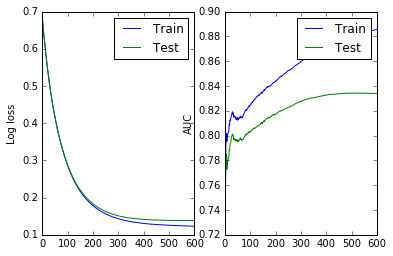

In [6]:
# xgb on bow + basic features
df_features = pd.concat([df_train, BOW().fit_transform(df_train)], axis=1)
pipeline = Pipeline([
    ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS))
])

X_train = pipeline.fit_transform(df_features)
y_train = df_target
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# best params so far using column/row subsampling, even longer training
learning_rate = 0.01
n_estimators = 600
max_depth = 6
subsample = 0.9
colsample_bytree = 0.85
min_child_weight = 1  # default

eval_metrics = ['logloss', 'auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(seed=0, learning_rate=learning_rate, n_estimators=n_estimators,
                    min_child_weight=min_child_weight, max_depth=max_depth,
                    colsample_bytree=colsample_bytree, subsample=subsample)
xgb = xgb.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets, verbose=False)

logloss = [xgb.evals_result_['validation_%d' % i]['logloss'] for i in range(len(eval_sets))]
logloss = np.array(logloss, dtype=float).T
auc = [xgb.evals_result_['validation_%d' % i]['auc'] for i in range(len(eval_sets))]
auc = np.array(auc, dtype=float).T

logloss_best_round = np.argmin(logloss, axis=0)
logloss_best = [logloss[logloss_best_round[0], 0], logloss[logloss_best_round[1], 1]]
auc_best_round = np.argmax(auc, axis=0)
auc_best = [auc[auc_best_round[0], 0], auc[auc_best_round[1], 1]]

print 'Best log loss train=%f (round=%d), test=%f (round=%d)' % (logloss_best[0], logloss_best_round[0], logloss_best[1], logloss_best_round[1])
print 'Best AUC train=%f (round=%d), test=%f (round=%d)' % (auc_best[0], auc_best_round[0], auc_best[1], auc_best_round[1])

plt.subplot(1, 2, 1)
plt.plot(logloss)
plt.legend(['Train', 'Test'])
plt.ylabel('Log loss')
plt.subplot(1, 2, 2)
plt.plot(auc)
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

importances = xgb.booster().get_fscore()
df_importance = pd.DataFrame(zip(importances.keys(), importances.values()), columns=['feature', 'importance'])
df_importance.sort_values('importance', ascending=False).reset_index(drop=True)

Dropped 34 features due to no variation
Introduced 59 features
Best log loss train=0.120128 (round=599), test=0.135678 (round=599)
Best AUC train=0.893298 (round=599), test=0.839750 (round=486)


,feature,importance
125,var38,4475
79,var15,2425
162,saldo_var30,1367
9,saldo_medio_var5_hace2,1270
8,saldo_medio_var5_hace3,1184
140,saldo_medio_var5_ult3,906
50,num_var22_ult3,789
86,num_var45_hace3,717
49,num_var22_ult1,715
139,saldo_medio_var5_ult1,568


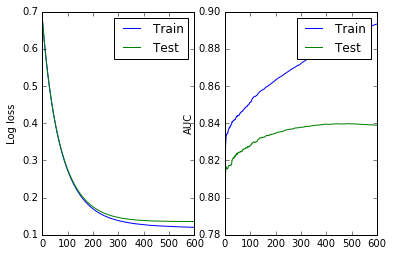

In [7]:
# xgb on basic features + "featurizer"
pipeline = Pipeline([
    ('cd', ColumnDropper(drop=CORRELATED_COLUMNS)),
    ('feat', Featurizer())
])

X_train = pipeline.fit_transform(df_train)
y_train = df_target
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# best params so far using column/row subsampling, even longer training
learning_rate = 0.01
n_estimators = 600
max_depth = 6
subsample = 0.9
colsample_bytree = 0.85
min_child_weight = 1  # default

eval_metrics = ['logloss', 'auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(seed=0, learning_rate=learning_rate, n_estimators=n_estimators,
                    min_child_weight=min_child_weight, max_depth=max_depth,
                    colsample_bytree=colsample_bytree, subsample=subsample)
xgb = xgb.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets, verbose=False)

logloss = [xgb.evals_result_['validation_%d' % i]['logloss'] for i in range(len(eval_sets))]
logloss = np.array(logloss, dtype=float).T
auc = [xgb.evals_result_['validation_%d' % i]['auc'] for i in range(len(eval_sets))]
auc = np.array(auc, dtype=float).T

logloss_best_round = np.argmin(logloss, axis=0)
logloss_best = [logloss[logloss_best_round[0], 0], logloss[logloss_best_round[1], 1]]
auc_best_round = np.argmax(auc, axis=0)
auc_best = [auc[auc_best_round[0], 0], auc[auc_best_round[1], 1]]

print 'Best log loss train=%f (round=%d), test=%f (round=%d)' % (logloss_best[0], logloss_best_round[0], logloss_best[1], logloss_best_round[1])
print 'Best AUC train=%f (round=%d), test=%f (round=%d)' % (auc_best[0], auc_best_round[0], auc_best[1], auc_best_round[1])

plt.subplot(1, 2, 1)
plt.plot(logloss)
plt.legend(['Train', 'Test'])
plt.ylabel('Log loss')
plt.subplot(1, 2, 2)
plt.plot(auc)
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

importances = xgb.booster().get_fscore()
df_importance = pd.DataFrame(zip(importances.keys(), importances.values()), columns=['feature', 'importance'])
df_importance.sort_values('importance', ascending=False)

BOW 31 words
Dropped 34 features due to no variation
Introduced 59 features
Best log loss train=0.120128 (round=599), test=0.135678 (round=599)
Best AUC train=0.893298 (round=599), test=0.839750 (round=486)


,feature,importance
0,var38,4475
1,var15,2425
2,saldo_var30,1367
3,saldo_medio_var5_hace2,1270
4,saldo_medio_var5_hace3,1184
5,saldo_medio_var5_ult3,906
6,num_var22_ult3,789
7,num_var45_hace3,717
8,num_var22_ult1,715
9,saldo_medio_var5_ult1,568


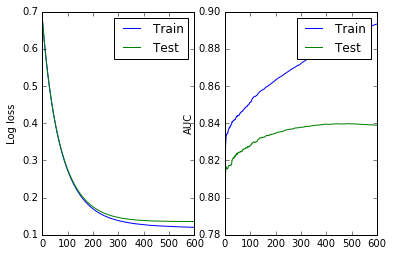

In [8]:
# xgb on bow + basic features + postprocessing
df_features = pd.concat([df_train, BOW().fit_transform(df_train)], axis=1)
pipeline = Pipeline([
    ('cd', ColumnDropper(drop=CORRELATED_COLUMNS)),
    ('feat', Featurizer())
])
X_train = pipeline.fit_transform(df_train)
y_train = df_target

X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# best params so far using column/row subsampling, even longer training
learning_rate = 0.01
n_estimators = 600
max_depth = 6
subsample = 0.9
colsample_bytree = 0.85
min_child_weight = 1  # default

eval_metrics = ['logloss', 'auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(seed=0, learning_rate=learning_rate, n_estimators=n_estimators,
                    min_child_weight=min_child_weight, max_depth=max_depth,
                    colsample_bytree=colsample_bytree, subsample=subsample)
xgb = xgb.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets, verbose=False)

logloss = [xgb.evals_result_['validation_%d' % i]['logloss'] for i in range(len(eval_sets))]
logloss = np.array(logloss, dtype=float).T
auc = [xgb.evals_result_['validation_%d' % i]['auc'] for i in range(len(eval_sets))]
auc = np.array(auc, dtype=float).T

logloss_best_round = np.argmin(logloss, axis=0)
logloss_best = [logloss[logloss_best_round[0], 0], logloss[logloss_best_round[1], 1]]
auc_best_round = np.argmax(auc, axis=0)
auc_best = [auc[auc_best_round[0], 0], auc[auc_best_round[1], 1]]

print 'Best log loss train=%f (round=%d), test=%f (round=%d)' % (logloss_best[0], logloss_best_round[0], logloss_best[1], logloss_best_round[1])
print 'Best AUC train=%f (round=%d), test=%f (round=%d)' % (auc_best[0], auc_best_round[0], auc_best[1], auc_best_round[1])

plt.subplot(1, 2, 1)
plt.plot(logloss)
plt.legend(['Train', 'Test'])
plt.ylabel('Log loss')
plt.subplot(1, 2, 2)
plt.plot(auc)
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

importances = xgb.booster().get_fscore()
df_importance = pd.DataFrame(zip(importances.keys(), importances.values()), columns=['feature', 'importance'])
df_importance.sort_values('importance', ascending=False).reset_index(drop=True)

BOW 31 words
Unknown int column ----> num_zero
Dropped 0 features due to no variation
Introduced 59 features
Best log loss train=0.119725 (round=599), test=0.135691 (round=599)
Best AUC train=0.894485 (round=599), test=0.840030 (round=455)


,feature,importance
0,var38,4348
1,var15,2359
2,saldo_var30,1338
3,saldo_medio_var5_hace2,1128
4,saldo_medio_var5_hace3,1041
5,saldo_medio_var5_ult3,912
6,num_var22_ult1,687
7,num_var22_ult3,677
8,num_var45_hace3,641
9,num_zero,598


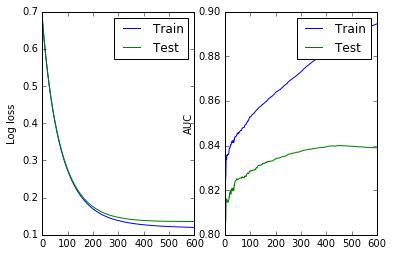

In [9]:
# xgb on basic features + zero features, bow, postprocessing (reordered)
bow = BOW().fit_transform(df_train)
pipeline = Pipeline([
    ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS))
])

X_train = pipeline.fit_transform(df_train)
X_train['num_zero'] = (X_train == 0).sum(axis=1)
X_train = pd.concat([X_train, bow], axis=1)
X_train = Featurizer().fit(X_train).transform(X_train)
y_train = df_target

X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# best params so far using column/row subsampling, even longer training
learning_rate = 0.01
n_estimators = 600
max_depth = 6
subsample = 0.9
colsample_bytree = 0.85
min_child_weight = 1  # default

eval_metrics = ['logloss', 'auc']
eval_sets = [(X_train, y_train), (X_test, y_test)]
xgb = XGBClassifier(seed=0, learning_rate=learning_rate, n_estimators=n_estimators,
                    min_child_weight=min_child_weight, max_depth=max_depth,
                    colsample_bytree=colsample_bytree, subsample=subsample)
xgb = xgb.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets, verbose=False)

logloss = [xgb.evals_result_['validation_%d' % i]['logloss'] for i in range(len(eval_sets))]
logloss = np.array(logloss, dtype=float).T
auc = [xgb.evals_result_['validation_%d' % i]['auc'] for i in range(len(eval_sets))]
auc = np.array(auc, dtype=float).T

logloss_best_round = np.argmin(logloss, axis=0)
logloss_best = [logloss[logloss_best_round[0], 0], logloss[logloss_best_round[1], 1]]
auc_best_round = np.argmax(auc, axis=0)
auc_best = [auc[auc_best_round[0], 0], auc[auc_best_round[1], 1]]

print 'Best log loss train=%f (round=%d), test=%f (round=%d)' % (logloss_best[0], logloss_best_round[0], logloss_best[1], logloss_best_round[1])
print 'Best AUC train=%f (round=%d), test=%f (round=%d)' % (auc_best[0], auc_best_round[0], auc_best[1], auc_best_round[1])

plt.subplot(1, 2, 1)
plt.plot(logloss)
plt.legend(['Train', 'Test'])
plt.ylabel('Log loss')
plt.subplot(1, 2, 2)
plt.plot(auc)
plt.legend(['Train', 'Test'])
plt.ylabel('AUC')

importances = xgb.booster().get_fscore()
df_importance = pd.DataFrame(zip(importances.keys(), importances.values()), columns=['feature', 'importance'])
df_importance.sort_values('importance', ascending=False).reset_index(drop=True)

In [10]:
# examining the effect of preprocessing/feature engineering on simple LR model -- base case

df_train_copy = df_train.copy()
X_train, X_test, y_train, y_test= train_test_split(df_train_copy, df_target, test_size=0.3, random_state=0)

pipeline = Pipeline([
    ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS)),
    ('std', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

el = SGDClassifier(random_state=0, loss='log', penalty='elasticnet', learning_rate='invscaling', eta0=0.1, alpha=0.001, n_iter=50)
el = el.fit(X_train, y_train)
y_pred = el.predict_proba(X_test)[:, -1]
print 'Elastic: %f' % roc_auc_score(y_test, y_pred)

el_bag = BaggingClassifier(SGDClassifier(random_state=0, loss='log', penalty='elasticnet', learning_rate='invscaling', eta0=0.1, alpha=0.001, n_iter=50), 
                           max_samples=0.999, max_features=0.999, n_estimators=10, random_state=0)
el_bag = el_bag.fit(X_train, y_train)
y_pred = el_bag.predict_proba(X_test)[:, -1]
print 'Elastic bag: %f' % roc_auc_score(y_test, y_pred)

Elastic: 0.799668
Elastic bag: 0.800595


In [11]:
# examining the effect of preprocessing/feature engineering on simple LR model

df_train_copy = df_train.copy()
df_train_copy.loc[df_train_copy['var3'] == -999999.000000, 'var3'] = 2.0
df_train_copy['num_zeros'] = (df_train_copy == 0).sum(axis=1)

X_train, X_test, y_train, y_test= train_test_split(df_train_copy, df_target, test_size=0.3, random_state=0)

# ecdf transform age
age_ecdf = ECDF(X_train['var15'])
X_train['var15'] = age_ecdf(X_train['var15'])
X_test['var15'] = age_ecdf(X_test['var15'])

# save for heurstic correction later
age = X_test['var15']

# 50k cutoff is slightly worse in this CV, but more conservative
# using mahalanobis as a feature is slightly better than removing
ec = EmpiricalCovariance()
ec = ec.fit(X_train)
m2 = ec.mahalanobis(X_train)
# X_train = X_train[m2 < 40000]
# y_train = y_train[m2 < 40000]
X_train['mahalanobis'] = ec.mahalanobis(X_train)
X_test['mahalanobis'] = ec.mahalanobis(X_test)

# clip
X_test = X_test.clip(X_train.min(), X_train.max(), axis=1)

pipeline = Pipeline([
    ('cd', ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS)),
    ('std', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

el = SGDClassifier(random_state=0, loss='log', penalty='elasticnet', learning_rate='invscaling', eta0=0.1, alpha=0.001, n_iter=50)
el = el.fit(X_train, y_train)
y_pred = el.predict_proba(X_test)[:, -1]
y_pred[age < 23] = 0
print 'Elastic: %f' % roc_auc_score(y_test, y_pred)

el_bag = BaggingClassifier(SGDClassifier(random_state=0, loss='log', penalty='elasticnet', learning_rate='invscaling', eta0=0.1, alpha=0.001, n_iter=50), 
                           max_samples=0.999, max_features=0.999, n_estimators=10, random_state=0)
el_bag = el_bag.fit(X_train, y_train)
y_pred = el_bag.predict_proba(X_test)[:, -1]
y_pred[age < 23] = 0
print 'Elastic bag: %f' % roc_auc_score(y_test, y_pred)

/Users/dean.wyatte/miniconda2/envs/kaggle-santander/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dean.wyatte/miniconda2/envs/kaggle-santander/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dean.wyatte/miniconda2/envs/kaggle-santander/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Elastic: 0.811874
Elastic bag: 0.812409


/Users/dean.wyatte/miniconda2/envs/kaggle-santander/lib/python2.7/site-packages/ipykernel/__main__.py:48: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [12]:
# examining the effect of preprocessing/feature engineering on simple LR model -- above plus one hot encoding

df_train_copy = df_train.copy()
df_train_copy.loc[df_train_copy['var3'] == -999999.000000, 'var3'] = 2.0
df_train_copy['num_zeros'] = (df_train_copy == 0).sum(axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_train_copy, df_target, test_size=0.3, random_state=1)

# ecdf transform age
age = X_test['var15']
age_ecdf = ECDF(X_train['var15'])
X_train['var15'] = age_ecdf(X_train['var15'])
X_test['var15'] = age_ecdf(X_test['var15'])

# 50k cutoff is slightly worse in this CV, but more conservative
ec = EmpiricalCovariance()
ec = ec.fit(X_train)
m2 = ec.mahalanobis(X_train)
# X_train = X_train[m2 < 40000]
# y_train = y_train[m2 < 40000]
X_train['mahalanobis'] = ec.mahalanobis(X_train)
X_test['mahalanobis'] = ec.mahalanobis(X_test)

# clip
X_test = X_test.clip(X_train.min(), X_train.max(), axis=1)

cd = ColumnDropper(drop=ZERO_VARIANCE_COLUMNS+CORRELATED_COLUMNS).fit(X_train)
X_train = cd.transform(X_train)
X_test = cd.transform(X_test)

# candidate columns for ohe with 1 < x < 5 unique values
oh_cols = set(['num_var20_0', 'num_var18', 'num_var18_0', 'num_var7_emit_ult1', 'num_meses_var13_medio_ult3', 'num_var13_medio', 'num_var29_0', 'num_reemb_var13_ult1', 'num_var20', 'num_var44', 'num_reemb_var33_ult1', 'num_trasp_var17_in_ult1', 'num_var8', 'num_trasp_var17_out_ult1', 'num_var13_medio_0', 'num_reemb_var17_hace3', 'ind_var43_recib_ult1', 'num_var29', 'delta_num_trasp_var33_out_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_reemb_var13_1y3', 'delta_imp_trasp_var33_out_1y3', 'num_var34', 'delta_imp_trasp_var17_out_1y3', 'imp_reemb_var33_ult1', 'delta_imp_reemb_var33_1y3', 'delta_imp_reemb_var13_1y3', 'num_var6', 'ind_var7_emit_ult1', 'num_var40', 'delta_imp_amort_var34_1y3', 'num_var39', 'ind_var7_recib_ult1', 'ind_var10_ult1', 'ind_var10cte_ult1', 'ind_var9_cte_ult1', 'ind_var9_ult1', 'ind_var43_emit_ult1', 'delta_imp_amort_var18_1y3', 'imp_trasp_var33_out_ult1', 'num_var34_0', 'ind_var24_0', 'ind_var24', 'num_trasp_var33_in_hace3', 'ind_var20', 'ind_var20_0', 'ind_var19', 'ind_var18', 'ind_var18_0', 'ind_var17', 'ind_var17_0', 'ind_var14', 'ind_var14_0', 'ind_var13', 'ind_var13_medio', 'ind_var13_medio_0', 'ind_var13_largo', 'ind_var13_largo_0', 'ind_var13_corto', 'ind_var13_corto_0', 'ind_var13_0', 'ind_var12', 'ind_var12_0', 'ind_var8', 'ind_var8_0', 'ind_var6', 'ind_var6_0', 'ind_var5', 'ind_var5_0', 'ind_var1', 'ind_var1_0', 'ind_var25_cte', 'ind_var26_0', 'num_var6_0', 'ind_var26', 'ind_var40_0', 'ind_var39_0', 'ind_var37', 'ind_var39', 'ind_var44_0', 'ind_var37_0', 'ind_var44', 'ind_var37_cte', 'ind_var26_cte', 'ind_var34', 'ind_var34_0', 'ind_var40', 'num_trasp_var33_out_ult1', 'ind_var33', 'ind_var32', 'ind_var32_0', 'ind_var32_cte', 'ind_var31', 'ind_var31_0', 'ind_var30', 'ind_var30_0', 'ind_var29', 'ind_var29_0', 'ind_var25', 'ind_var25_0', 'ind_var33_0', 'ind_var41_0', 'saldo_var34', 'num_venta_var44_hace3', 'num_trasp_var17_in_hace3', 'num_aport_var33_ult1', 'num_meses_var29_ult3', 'delta_imp_trasp_var17_in_1y3', 'delta_imp_trasp_var33_in_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_imp_reemb_var17_1y3', 'num_trasp_var33_in_ult1', 'saldo_medio_var13_medio_ult1', 'saldo_var13_medio', 'num_var8_0', 'num_var33', 'num_var1', 'num_var1_0', 'num_var13_corto_0', 'saldo_var18', 'num_var13_corto', 'num_var24', 'num_var44_0', 'num_var40_0', 'num_meses_var8_ult3', 'num_compra_var44_hace3', 'num_aport_var33_hace3', 'num_var12', 'num_var24_0', 'num_meses_var12_ult3', 'num_meses_var5_ult3', 'num_meses_var13_largo_ult3', 'num_meses_var44_ult3', 'num_meses_var39_vig_ult3', 'num_meses_var33_ult3', 'num_meses_var13_corto_ult3', 'num_var14', 'num_var33_0', 'num_meses_var17_ult3'])
oh_cols &= set(X_train.columns)
new_columns = []

# join data temporarily
split_idx = X_train.shape[0]
X_all = pd.concat([X_train, X_test], axis=0)

for col in oh_cols:
    labels = LabelEncoder().fit_transform(X_all[[col]])
    ohe = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))
    new_columns.append(ohe)

X_all = X_all.drop(oh_cols, axis=1)
X_all = np.hstack([X_all.values, np.hstack(new_columns)])
X_train = X_all[:split_idx]
X_test = X_all[split_idx:]

std = StandardScaler().fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

el = SGDClassifier(random_state=0, loss='log', penalty='elasticnet', learning_rate='invscaling', eta0=0.1, alpha=0.001, n_iter=50)
el = el.fit(X_train, y_train)
y_pred = el.predict_proba(X_test)[:, -1]
y_pred[age < 23] = 0
print 'Elastic: %f' % roc_auc_score(y_test, y_pred)

el_bag = BaggingClassifier(SGDClassifier(random_state=0, loss='log', penalty='elasticnet', learning_rate='invscaling', eta0=0.1, alpha=0.001, n_iter=50), 
                           max_samples=0.999, max_features=0.999, n_estimators=10, random_state=0)
el_bag = el_bag.fit(X_train, y_train)
y_pred = el_bag.predict_proba(X_test)[:, -1]
y_pred[age < 23] = 0
print 'Elastic bag: %f' % roc_auc_score(y_test, y_pred)

/Users/dean.wyatte/miniconda2/envs/kaggle-santander/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dean.wyatte/miniconda2/envs/kaggle-santander/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dean.wyatte/miniconda2/envs/kaggle-santander/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Elastic: 0.809368
Elastic bag: 0.808356


/Users/dean.wyatte/miniconda2/envs/kaggle-santander/lib/python2.7/site-packages/ipykernel/__main__.py:64: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
